In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from enum import Enum
from skimage import data
from sklearn.externals import joblib
import copy
import sqlite3
import os.path
%matplotlib inline
conn = sqlite3.connect('sessions.db')
c = conn.cursor()
class Participant(Enum):
     none = 0
     adult = 1
     child = 2
     pet = 3
rows = [r for r in c.execute('SELECT * FROM readings')]
image_paths = ['image_data/{}'.format(r[5]) for r in rows]
X = [np.array(data.imread(p)).flatten() for p in image_paths]
y = [Participant[r[2]].value for r in rows]

In [34]:
window_width = 18
window_height = 26
window_size = (window_height, window_width)

# Extract Negative Samples

In [3]:
X_none = [data.imread(c[0]) for c in zip(image_paths, y) if c[1] == 0]

In [4]:
def slide(img, size, stride):
    h = size[0]
    w = size[1]
    dy = stride[0]
    dx = stride[1]

    x_range = list(range(0, img.shape[1], dx))
    y_range = list(range(0, img.shape[0], dy))
    for y in y_range:
        for x in x_range:
            if (y+h) < img.shape[0] and (x+w) < img.shape[1]:
                yield img[y:y+h,x:x+w]

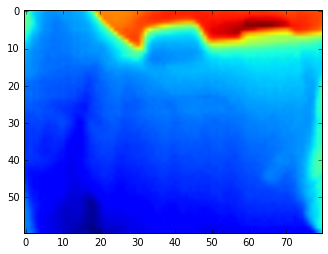

In [5]:
plt.figure()
plt.imshow(X_none[0])

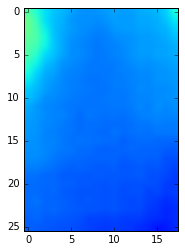

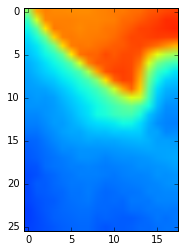

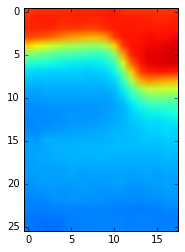

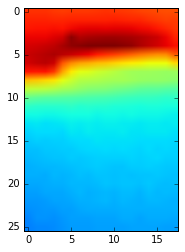

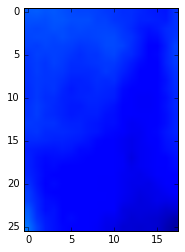

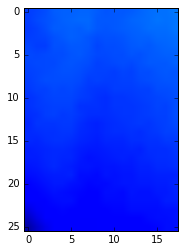

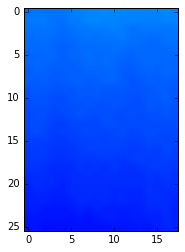

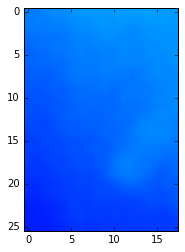

In [6]:
for sample in slide(X_none[0], (window_height, window_width), (window_height, window_width)):
    plt.figure()
    plt.imshow(sample, vmax=255, vmin=0)

In [7]:
def negative_samples(X_none):
    for x in X_none:
        for sample in slide(x, (window_height, window_width), (window_height, window_width)):
            yield sample
X_neg = list(negative_samples(X_none))

In [8]:
def positive_samples(saved_face_regions, size):
    for row in saved_face_regions:
        # some images may not exist after data cleaning
        if os.path.isfile(row[0]):
            img = data.imread(row[0])
            y = row[1][0]
            x = row[1][1]
            yield img[x:x+size[1],y:y+size[0]]

saved_face_regions = np.load('face_regions.npy')
X_pos = [x for x in positive_samples(saved_face_regions, (window_width,window_height)) if x.shape == (window_height,window_width)]

# Combine Sliding Window Samples

In [9]:
X = [x.flatten() for x in np.concatenate((X_neg,X_pos))]
y = np.concatenate((np.zeros(len(X_neg)), np.ones(len(X_pos))))

# Plots of Various Classifier Accuracy

/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


([<matplotlib.axis.YTick at 0x110454208>,
 <a list of 10 Text yticklabel objects>)

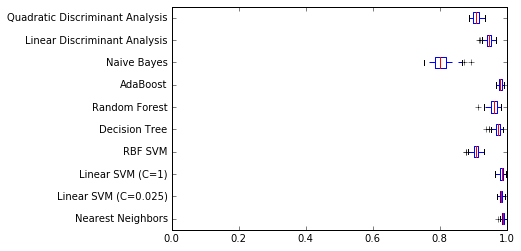

In [10]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM (C=0.025)", "Linear SVM (C=1)", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="linear", C=1),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

#X = StandardScaler().fit_transform(X)
# y_train will be an array that designates if there is a person or not a person in an image
# X_train is all of our images
classifier_scores = []
plt.xlim((0,1))
for name, clf in zip(names, classifiers):  
    scores = []
    for j in range(0,100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
        # iterate over classifiers

        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    classifier_scores.append(scores)

plt.boxplot(classifier_scores, vert=False)
plt.yticks(range(1,len(classifiers) + 1), names)

# Save the Best Classifier (Linear SVM)

In [11]:
max_score = 0
clf = SVC(kernel="linear", C=0.025)
for j in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    # iterate over classifiers

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if (score > max_score):
        max_clf = copy.deepcopy(clf)
        max_score = score

print(max_score)        
joblib.dump(max_clf, 'classifiers/classifier-sliding-2.7.pkl')

0.995454545455


['classifiers/classifier-sliding-2.7.pkl',
 'classifiers/classifier-sliding-2.7.pkl_01.npy',
 'classifiers/classifier-sliding-2.7.pkl_02.npy',
 'classifiers/classifier-sliding-2.7.pkl_03.npy',
 'classifiers/classifier-sliding-2.7.pkl_04.npy',
 'classifiers/classifier-sliding-2.7.pkl_05.npy',
 'classifiers/classifier-sliding-2.7.pkl_06.npy',
 'classifiers/classifier-sliding-2.7.pkl_07.npy',
 'classifiers/classifier-sliding-2.7.pkl_08.npy',
 'classifiers/classifier-sliding-2.7.pkl_09.npy',
 'classifiers/classifier-sliding-2.7.pkl_10.npy',
 'classifiers/classifier-sliding-2.7.pkl_11.npy']

# Sliding Window w/ Stride

In [12]:
adult_rows = [r for r in c.execute("SELECT * FROM readings WHERE subject_type='adult'")]
image_paths = ['image_data/{}'.format(r[5]) for r in adult_rows]
X_adult = [data.imread(p) for p in image_paths]

In [13]:
clf = joblib.load('classifiers/classifier-sliding.pkl')

2.0


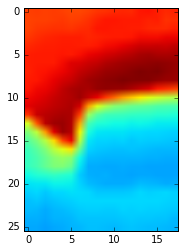

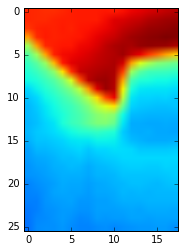

In [14]:
X_none_slices = [x for x in slide(X_none[1], (window_height, window_width), (5,5))]
X_none_pred = clf.predict([x.flatten() for x in X_none_slices])
print(sum(X_none_pred)) # Number of misclassified people

for p,frame in zip(X_none_pred,X_none_slices):
    if p == 1:
        plt.figure();
        plt.imshow(frame, vmax=255, vmin=0)

4.0


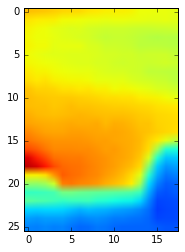

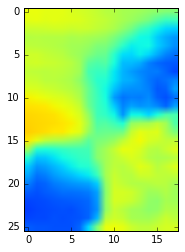

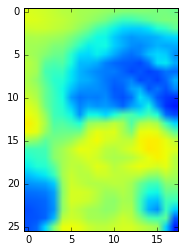

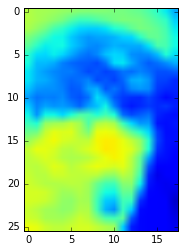

In [15]:
X_adult_slices = [x for x in slide(X_adult[0], (window_height, window_width), (5,5))]
X_adult_pred = clf.predict([x.flatten() for x in X_adult_slices])
print(sum(X_adult_pred)) # Number of correctly classified faces

for p,frame in zip(X_adult_pred,X_adult_slices):
    if p == 1:
        plt.figure();
        plt.imshow(frame, vmax=255, vmin=0)

# More Negative Data

In [16]:
def negative_samples(X_none):
    for x in X_none:
        for sample in slide(x, (window_height, window_width), (5, 5)):
            yield sample

none_rows = [r for r in c.execute("SELECT * FROM readings WHERE subject_type='none'")]
image_paths = ['image_data/{}'.format(r[5]) for r in none_rows]
X_none = [data.imread(p) for p in image_paths]
X_neg = list(negative_samples(X_none))
len(X_neg)

11375

In [17]:
len(X_pos)

99

In [18]:
X = [x.flatten() for x in np.concatenate((X_neg,X_pos))]
y = np.concatenate((np.zeros(len(X_neg)), np.ones(len(X_pos))))

KeyboardInterrupt: 

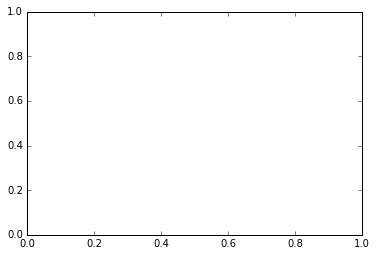

In [20]:
h = .02  # step size in the mesh

names = ["Linear SVM (C=0.025)", "Linear SVM (C=1)", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(kernel="linear", C=1),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

#X = StandardScaler().fit_transform(X)
# y_train will be an array that designates if there is a person or not a person in an image
# X_train is all of our images
classifier_scores = []
plt.xlim((0,1))
for name, clf in zip(names, classifiers):  
    scores = []
    for j in range(0,100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
        # iterate over classifiers

        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    classifier_scores.append(scores)

plt.boxplot(classifier_scores, vert=False)
plt.yticks(range(1,len(classifiers) + 1), names)

0.998910675381


{'boxes': [<matplotlib.lines.Line2D at 0x110cd4128>],
 'caps': [<matplotlib.lines.Line2D at 0x110cdab70>,
 'fliers': [<matplotlib.lines.Line2D at 0x110cdfcf8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x110cdf4e0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x110cd4b00>,
  <matplotlib.lines.Line2D at 0x110cd4c50>]}

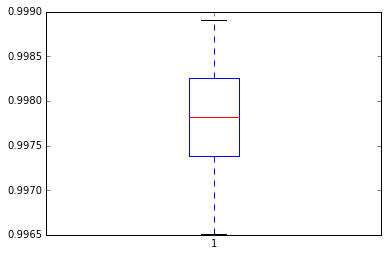

In [21]:
max_score = 0
svm_scores = []
clf = SVC(kernel="linear", C=1)
for j in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    # iterate over classifiers

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    svm_scores.append(score)
    if (score > max_score):
        max_clf = copy.deepcopy(clf)
        max_score = score

print(max_score)
plt.boxplot(svm_scores)

# Add Selected IRIS dataset

In [35]:
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from scipy.misc import bytescale

def crop(img, size, corner):
    y = corner[0]
    x = corner[1]
    h = size[0]
    w = size[1]
    return img[y:y+h, x:x+w]

def process_iris_sample(frame, window_size):
    h = window_size[0]
    w = window_size[1]

    # Values which specify how to crop IRIS images to fit sliding window
    ROI_start_y = 13
    ROI_start_x = 100
    ROI_height = 207
    ROI_scale = ROI_height / h
    ROI_width = int(np.floor(ROI_scale * w))

    cropped_frame = crop(frame, (ROI_height, ROI_width), (ROI_start_y, ROI_start_x))
    resized_frame = resize(cropped_frame, (h, w))
    gray_frame = rgb2gray(resized_frame)
    return bytescale(gray_frame, cmin=0.0, cmax=1.0)

In [36]:
raw_iris = io.imread_collection('external_data/selected_iris/*.bmp')
processed_iris = [process_iris_sample(img, (window_height, window_width)) for img in raw_iris]

## Test/train combined split

In [37]:
X = [x.flatten() for x in np.concatenate((X_neg,X_pos,processed_iris))]
y = np.concatenate((np.zeros(len(X_neg)), np.ones(len(X_pos) + len(processed_iris))))

0.989845568014


{'boxes': [<matplotlib.lines.Line2D at 0x1196a6400>],
 'caps': [<matplotlib.lines.Line2D at 0x1196aae48>,
 'fliers': [<matplotlib.lines.Line2D at 0x1196b0fd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1196b07b8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1196a6dd8>,
  <matplotlib.lines.Line2D at 0x1196a6f28>]}

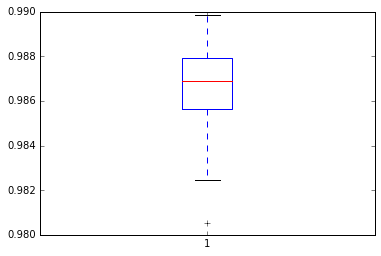

In [38]:
max_score = 0
svm_scores = []
clf = SVC(kernel="linear", C=1)
for j in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    # iterate over classifiers

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    svm_scores.append(score)
    if (score > max_score):
        max_clf = copy.deepcopy(clf)
        max_score = score

print(max_score)
plt.boxplot(svm_scores)

9.0


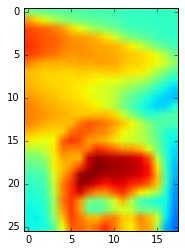

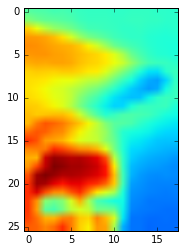

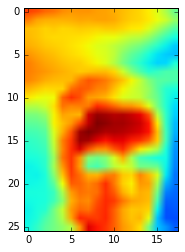

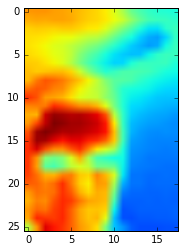

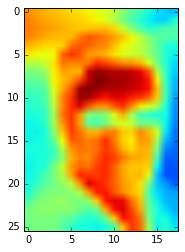

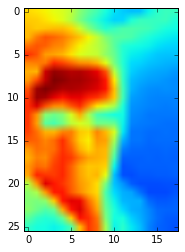

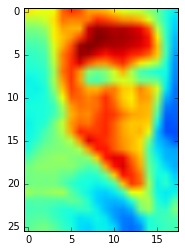

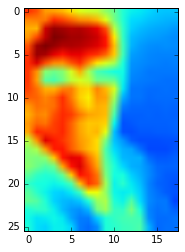

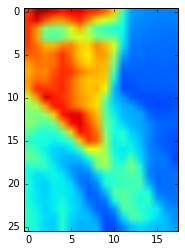

In [52]:
X_adult_slices = [x for x in slide(X_adult[100], (window_height, window_width), (5,5))]
X_adult_pred = clf.predict([x.flatten() for x in X_adult_slices])
print(sum(X_adult_pred)) # Number of correctly classified faces

for p,frame in zip(X_adult_pred,X_adult_slices):
    if p == 1:
        plt.figure();
        plt.imshow(frame, vmax=255, vmin=0)